In [ ]:
!pip install tensorflow==2.2.0

In [108]:
model_folder_path = 'drive/My Drive/Tibame_AIoT_Project'
img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/cleandataset'
test_img_path = 'drive/My Drive/Tibame_AIoT_Project/test'
IMG_SIZE = 224

# import tensorflow as tf
# from tensorflow import keras
# from keras.callbacks import ModelCheckpoint,EarlyStopping
# from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
# from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
# from keras.models import Model, Sequential
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
# from keras import metrics

# from keras.models import load_model
# import os

# print(tf.__version__)
# print(keras.__version__)

In [ ]:
#
# Use onnxruntime to predict
#
!pip install onnxruntime

!pip install mtcnn
# VGGFace: https://github.com/rcmalli/keras-vggface
!pip install keras_vggface
!pip install keras_applications

In [ ]:
import onnxruntime as rt
import numpy as np
from glob import glob
import os
import cv2
import time

from mtcnn import MTCNN
from keras_vggface.utils import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
detector = MTCNN()

In [ ]:
sess = rt.InferenceSession(os.path.join(model_folder_path,"resnet_512-128.onnx"))

In [ ]:
input_name = sess.get_inputs()[0].name
print("input name", input_name)
input_shape = sess.get_inputs()[0].shape
print("input shape", input_shape)
input_type = sess.get_inputs()[0].type
print("input type", input_type)

input name input_4
input shape ['N', 224, 224, 3]
input type tensor(float)


In [ ]:
output = sess.get_outputs()
print("output name:", output[0].name, output[1].name)
print("output shape", output[0].shape, output[1].shape)
print("output type", output[0].type, output[1].type)

output name: age gender
output shape ['N', 8] ['N', 2]
output type tensor(float) tensor(float)


In [76]:
# detect face
def detect_faces(img):
    face_imgs = []

    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
     
    return face_imgs, results

In [120]:
# 每張圖片可偵測多個人臉,切下臉的部分,並使用借來的模型的預處理方式來作預處理
def preprocess_image(image):
    faces, raw_results = detect_faces(image)
    if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
        print('No face')
        return []
    # print(faces[0].shape) 

    prepro_faces = []
    for face in faces:
        crop_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        
        # 使用借來的模型的預處理方式來作預處理
        prepro_face = preprocess_input(np.array(crop_face, dtype=float)) 
        
        prepro_faces.append(crop_face)

    return prepro_faces, raw_results   

In [121]:
# 從data_paths的每張圖片偵測一個人臉,切下臉的部分,並做預處理
def get_images(base_path, data_paths, y_data, batch_size=1):
    n = len(data_paths)
    # i = 0
    # data_paths = data_paths
    
    #while i < n:    
    x_ori, x_norm, y_age, y_gender = [], [], [], []
    #i_batch = i
    for idx in range(batch_size):
        path = data_paths[idx]
        #print("n:", n, "idx:", i, "cls:", y_data[i], path)
    
        # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
        try:          
            img = cv2.imread(os.path.join(base_path, path))[:,:,::-1]
        except:
            print('imread failed')
            idx = idx + 1
            continue                   

        prepro_faces, _ = preprocess_image(img)
        #print(prepro_faces[0].shape) 
        if len(prepro_faces) == 0:
            idx = idx + 1
            continue               


        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(prepro_faces[0])
        if len(y_data) != 0:
            y_age.append(y_data[idx][0])
            y_gender.append(y_data[idx][1])
        
        idx = idx + 1


    # print("len(image_data)",len(x_ori))
    # plt.figure(figsize=(10, 40))
    # for j,m in enumerate(x_ori):
    #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
    #     plt.title("idx:{} y_data:{}".format(i_batch+j, y_data[i_batch+j]))
    #     plt.axis("off")
    #     plt.imshow(m)
    # plt.show() 

    
    # 2個輸出: age, gender  
    # print(type(y_age), len(y_age), y_age[:8])
    # print(type(y_gender), len(y_gender), y_gender[:8])
    if len(y_data) != 0:
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
    else:
        y_category = []

    # print(type(np.array(x_norm)), np.array(x_norm).shape)
    # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))

    return np.array(x_ori), np.array(x_norm), y_category
    #print('while end', i, n)

In [122]:
files = glob(test_img_path + '/*.jpg')
files

['drive/My Drive/Tibame_AIoT_Project/test/7.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/4.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/3.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/6.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/2.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/5.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/1.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/8.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/9.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/10.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/11.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/12.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/13.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/14.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/15.jpg',
 'drive/My Drive/Tibame_AIoT_Project/test/16.jpg']

In [123]:
# x_data = ['m30/733802_1957-01-15_1991.jpg', 'f40/340560_1947-08-24_1989.jpg']
# base_path = img_folder_path
x_data = files
base_path = ""
x_ori, x_input, y_category = get_images(base_path, x_data, [], batch_size=len(x_data))

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [125]:
# path='m30/733802_1957-01-15_1991.jpg'
# img = preprocess_image(os.path.join(img_folder_path, path))
pred = sess.run([sess.get_outputs()[0].name,sess.get_outputs()[1].name], {input_name: x_input.astype('float32')})
#pred = age_gender_model.predict(img)
pred_age = np.array(pred[0]).argmax(axis=-1)
pred_gender = np.array(pred[1]).argmax(axis=-1)
print("predict age:",pred_age)
print("predict gender:",pred_gender)

predict age: [1 1 7 1 4 1 1 1 3 1 3 5 5 5 2 6]
predict gender: [1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1]


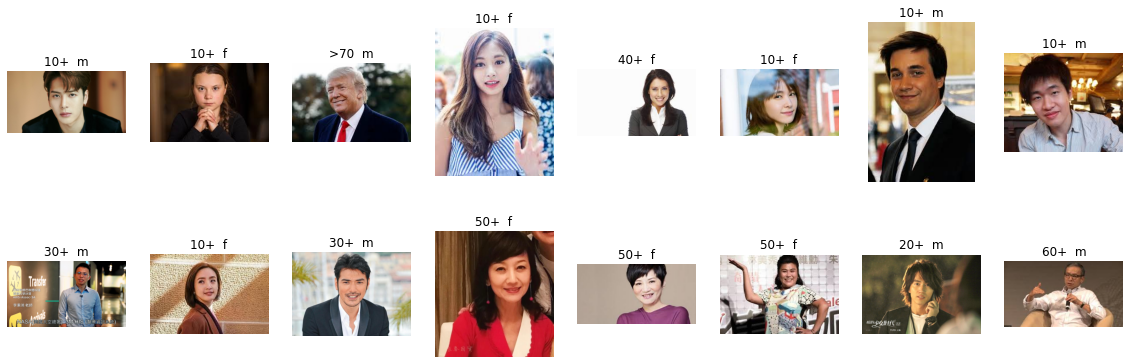

In [126]:
cls2age = {0: '<10', 1: '10+', 2: '20+', 3: '30+', 4: '40+', 5: '50+', 6: '60+', 7: '>70'}
cls2gender = {0: 'f', 1: 'm'}

plt.figure(figsize=(20, 10))
col = 8
row = len(x_ori)//col + 1
for i,m in enumerate(x_ori):
    plt.subplot(row, col, i+1)
    plt.title("{}  {}".format(cls2age[pred_age[i]], cls2gender[pred_gender[i]]))
    plt.axis("off")
    plt.imshow(m)
plt.show() 

In [134]:
# 用opencv讀取影片並做inference
from google.colab.patches import cv2_imshow
p1 = cv2.VideoCapture("jin-ma-53.mp4")
print("高:", p1.get(4))
print("寬:", p1.get(3))
print("總影格:", p1.get(7))
print("FPS:", p1.get(5))
p1.set(1, 600) # set 當前影格
while p1.isOpened()==True:
    ret, frame = p1.read()
    if ret == True:
        frame_no = p1.get(1)
        print("當前影格:", frame_no, type(frame_no))
        if frame_no > 605.0:
            break
        start = time.time()
        #偵測一個frame中的多張臉, 切下臉的部分, 並做預處理
        prepro_faces, raw_results = preprocess_image(frame)
        x_input = np.array(prepro_faces)
        #第一個輸出是age,第二個輸出是gender
        pred = sess.run([sess.get_outputs()[0].name,sess.get_outputs()[1].name], {input_name: x_input.astype('float32')})
 
        #標出預測結果
        for i in range(len(prepro_faces)):
            pred_age = np.array(pred[0][i]).argmax(axis=-1)
            pred_gender = np.array(pred[1][i]).argmax(axis=-1)

            x1, y1, width, height = raw_results[i]['box']
            cv2.rectangle(frame, (x1,y1), (x1+width, y1+height), (255,255,255), 2)
            text = "{},{}".format(cls2age[pred_age], cls2gender[pred_gender])
            cv2.putText(frame, text, (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)



        end = time.time()
        print("FPS: %.2f" % (1 / (end - start)))
        print("predict age:",pred_age)
        print("predict gender:",pred_gender)  
        cv2_imshow(frame)
        if cv2.waitKey(33) != -1: #按任意鍵離開(若沒按鍵則 cv2.waitKey() 會回傳-1)
            break
    else:
        break
p1.release()		
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.